In [1]:
%%time

#Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
from gurobipy import Model
from gurobipy import GRB

Wall time: 533 ms


In [2]:
%%time

#Variables that controls output of the program
nodes = 20
orders = 10
drivers = 5
driveCap = 2

order_assignment = {}
order_assignment_cost = {}
order_assignment_plan = {}

Wall time: 0 ns


In [3]:
%%time

#Generate random capasities for drivers
cap = []
for i in range(drivers):
    cap.append(random.randint(1,driveCap))

print(cap)
print(sum(cap))

[2, 2, 1, 1, 1]
7
Wall time: 998 µs


In [4]:
%%time

#Decide minimum assignment
minimum_assignment = min(orders,sum(cap))
print(minimum_assignment)

7
Wall time: 0 ns


In [5]:
%%time

#Generate random connected graph
G = nx.gnp_random_graph(nodes,0.3)
while(not nx.is_connected(G)):
        G = nx.gnp_random_graph(nodes,0.3)

#Generate random weights
labels = {}
        
for (u, v) in G.edges():
    w = random.randint(2,10)
    G.edges[u,v]['weight'] = w
    labels[(u,v)] = w

Wall time: 1.02 ms


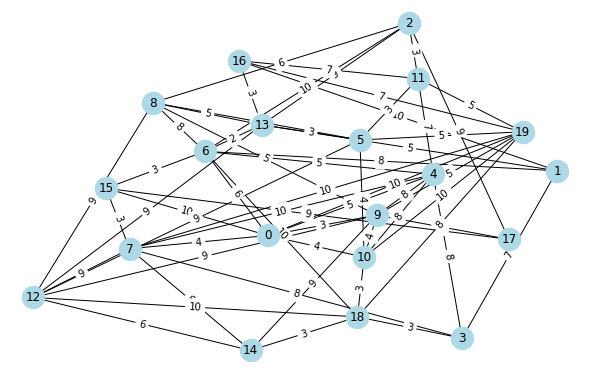

Wall time: 258 ms


In [6]:
%%time

#Plot graph
plt.figure(figsize=(8,5))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, node_color='lightblue', with_labels=True, node_size=500)
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, label_pos = 0.5)
plt.show()

In [7]:
%%time

#Place drivers to random locations
driverLocation = []
for i in range(drivers):
    driverLocation.append(random.sample(list(G.nodes), 1)[0])
print(driverLocation)

[9, 7, 17, 10, 2]
Wall time: 0 ns


In [8]:
%%time

#Generate random orders as a pairs of nodes
orderLocation = []
for i in range(orders):
    orderLocation.append(random.sample(list(G.nodes), 2))
print(orderLocation)

[[10, 1], [17, 12], [10, 3], [6, 5], [7, 19], [15, 6], [5, 19], [3, 14], [2, 3], [10, 14]]
Wall time: 0 ns


In [9]:
%%time

#Generate order combinations
orderCombo = []
s = set(i for i in range(orders))
for i in range(driveCap):
    for j in list(itertools.combinations(s,i+1)):
        orderCombo.append(list(j))
        
print(orderCombo)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 6], [5, 7], [5, 8], [5, 9], [6, 7], [6, 8], [6, 9], [7, 8], [7, 9], [8, 9]]
Wall time: 0 ns


In [10]:
%%time

#Function to calculate cost for a driver orderCombo pair
def getCost(d,oc):
    
    #Create an empty travel list
    travelList = []
    
    #Add all the location from orders into travel list prefixed by position
    for i in orderCombo[oc]:
        travelList.append(str(i)+'s'+str(orderLocation[i][0]))
        travelList.append(str(i)+'d'+str(orderLocation[i][1]))
        
    #print(travelList)
    #print()
    
    #Generate all possible travel options
    travel_options = list(itertools.permutations(travelList))
    
    #print(travel_options)
    #print()
    
    #Filter valid travel options
    valid_travel_options = []
    
    for i in travel_options:
        
        flag = True
        
        for c in orderCombo[oc]:
            if i.index(str(c)+'s'+str(orderLocation[c][0])) >= i.index(str(c)+'d'+str(orderLocation[c][1])):
                flag = False
                
        if flag:
            valid_travel_options.append(i)
            
    #print(valid_travel_options)
    #print()
    
    #Variables to store best cost and travel plan
    cost = 9999999
    plan = []
    
    #Calculate cost for each valid travel option
    for i in valid_travel_options:
        
        check_travel_list = []
        check_travel_list.append(driverLocation[d])
        
        for t in i:
            if 's' in t:
                check_travel_list.append(int(t.split('s')[1]))
            if 'd' in t:
                check_travel_list.append(int(t.split('d')[1]))
        
        #print(check_travel_list)
    
        total = 0
        for k in range(len(check_travel_list)-1):
            total = total + nx.dijkstra_path_length(G,check_travel_list[k],check_travel_list[k+1])
            
        if total < cost:
            cost = total
            plan = check_travel_list
            
        #print(total)
    
    order_assignment_plan[(d,oc)] = plan
    #print(plan)
    return cost

print(getCost(0,0))
print(order_assignment_plan)

16
{(0, 0): [9, 10, 1]}
Wall time: 997 µs


In [11]:
%%time

#matrix for estimated order completion time from current location    
estimated_time = []

#Populate estimated_time matrix
for i in range(drivers):
    temp = []
    for j in range(len(orderCombo)):
        temp.append(getCost(i,j))
    estimated_time.append(temp)
    
#Values of estimated_time
for i in range(drivers):
    for j in range(len(orderCombo)):
        print('{0:<2}'.format(estimated_time[i][j]), end = ' ')
    print()

16 15 10 14 17 13 13 16 27 10 36 17 26 35 25 26 29 34 23 28 29 34 26 29 28 39 22 24 28 24 24 16 27 16 23 18 19 30 35 24 23 23 32 41 26 23 28 39 22 30 33 24 33 16 33 
20 22 14 11 10 6  16 14 32 14 41 21 27 30 27 30 32 39 27 35 34 30 30 36 35 46 29 21 25 21 28 20 32 20 16 11 16 27 32 21 16 16 25 34 25 16 25 32 21 29 36 28 38 20 38 
19 12 13 17 20 12 16 19 25 13 33 20 29 38 28 29 32 32 26 25 26 31 23 26 25 36 19 27 31 27 27 19 25 19 26 17 22 33 34 27 26 26 35 43 29 22 31 38 25 33 31 27 31 19 31 
12 19 6  14 18 14 9  12 26 6  33 13 22 31 21 22 25 31 19 31 33 38 30 29 32 43 25 24 24 20 20 12 26 12 24 19 19 29 35 23 24 24 28 42 22 24 24 39 18 26 29 20 32 12 32 
22 21 16 15 26 16 11 22 16 16 42 23 31 41 31 32 35 23 29 34 35 40 32 31 34 33 28 25 34 30 26 22 16 22 31 21 20 31 25 25 32 27 38 34 32 26 34 29 28 28 22 26 22 22 22 
Wall time: 176 ms


In [12]:
%%time

#Function to get index of variables from decision matrix if it contains specific order
def getVarIndex(x):
    temp = []
    c = 0
    
    #Search in all order combinations
    for i in orderCombo:
        #If order is found in the combination, then add index of the combination to the list
        if x in i:
            temp.append(c)
        c = c+1
        
    return temp

print(getVarIndex(0))

[0, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Wall time: 0 ns


In [13]:
%%time

#Initialize model
m = Model("Linear_programming_for_base_model_4")

Using license file C:\Users\Neel\gurobi.lic
Academic license - for non-commercial use only
Wall time: 2 ms


In [14]:
%%time

#matrix for decision variables
decision_matrix = []

#Populate decision matrix
for i in range(drivers):
    temp = []
    for j in range(len(orderCombo)):
        temp.append(m.addVar(lb=0, ub=1, vtype = GRB.BINARY))
    decision_matrix.append(temp)
    
print(len(decision_matrix),'X',len(decision_matrix[0]))

5 X 55
Wall time: 0 ns


In [15]:
%%time

#matrix for control variables
control_matrix = []

#Populate control matrix
for i in range(drivers):
    temp = []
    for j in range(orders):
        temp.append(m.addVar(lb=0, ub=1, vtype = GRB.BINARY))
    control_matrix.append(temp)
    
print(len(control_matrix),'X',len(control_matrix[0]))

5 X 10
Wall time: 998 µs


In [16]:
%%time

#Initialize objective function
obj = 0

#Construction of objective function
for i in range(drivers):
    for j in range(len(orderCombo)):
        obj = obj + decision_matrix[i][j]*estimated_time[i][j]

#Insert objective function to the model
m.setObjective(obj,GRB.MINIMIZE)

print('Objective set to minimize total cost for all the selected driver order-combo pairs.')

Objective set to minimize total cost for all the selected driver order-combo pairs.
Wall time: 997 µs


In [17]:
%%time

#Formulate and insert constraint for driver capasity
for i in range(drivers):
    const = 0
    for j in range(len(orderCombo)):
        const = const + decision_matrix[i][j]
    m.addConstr(const <= 1)
    
#Formulate and insert constraint for order assignment to atmost one driver
for i in range(len(orderCombo)):
    const = 0
    for j in range(drivers):
        const = const + decision_matrix[j][i]
    m.addConstr(const <= 1)
    
print('Constraint are set.')

Constraint are set.
Wall time: 996 µs


In [18]:
%%time

#Conditions that controls decision matrix
for i in range(drivers):
    for j in range(orders):
        condition = 0
        
        #Print partial condition
        print(i,j,getVarIndex(j))
        
        #Construct condition
        for k in getVarIndex(j):
            condition += decision_matrix[i][k]
            
        #Add constraint to the model
        m.addConstr((control_matrix[i][j] == 1) >> (condition == 1))
        
print('Conditional constraints added')

#Update model
m.update()

0 0 [0, 10, 11, 12, 13, 14, 15, 16, 17, 18]
0 1 [1, 10, 19, 20, 21, 22, 23, 24, 25, 26]
0 2 [2, 11, 19, 27, 28, 29, 30, 31, 32, 33]
0 3 [3, 12, 20, 27, 34, 35, 36, 37, 38, 39]
0 4 [4, 13, 21, 28, 34, 40, 41, 42, 43, 44]
0 5 [5, 14, 22, 29, 35, 40, 45, 46, 47, 48]
0 6 [6, 15, 23, 30, 36, 41, 45, 49, 50, 51]
0 7 [7, 16, 24, 31, 37, 42, 46, 49, 52, 53]
0 8 [8, 17, 25, 32, 38, 43, 47, 50, 52, 54]
0 9 [9, 18, 26, 33, 39, 44, 48, 51, 53, 54]
1 0 [0, 10, 11, 12, 13, 14, 15, 16, 17, 18]
1 1 [1, 10, 19, 20, 21, 22, 23, 24, 25, 26]
1 2 [2, 11, 19, 27, 28, 29, 30, 31, 32, 33]
1 3 [3, 12, 20, 27, 34, 35, 36, 37, 38, 39]
1 4 [4, 13, 21, 28, 34, 40, 41, 42, 43, 44]
1 5 [5, 14, 22, 29, 35, 40, 45, 46, 47, 48]
1 6 [6, 15, 23, 30, 36, 41, 45, 49, 50, 51]
1 7 [7, 16, 24, 31, 37, 42, 46, 49, 52, 53]
1 8 [8, 17, 25, 32, 38, 43, 47, 50, 52, 54]
1 9 [9, 18, 26, 33, 39, 44, 48, 51, 53, 54]
2 0 [0, 10, 11, 12, 13, 14, 15, 16, 17, 18]
2 1 [1, 10, 19, 20, 21, 22, 23, 24, 25, 26]
2 2 [2, 11, 19, 27, 28, 29, 30, 

In [19]:
%%time

#Formulate and insert constraint for driver capasity
for i in range(drivers):
    const = 0
    for j in range(orders):
        const = const + control_matrix[i][j]
    m.addConstr(const <= cap[i])
    
#Formulate and insert constraint for order assignment to atmost one driver
for i in range(orders):
    const = 0
    for j in range(drivers):
        const = const + control_matrix[j][i]
    m.addConstr(const <= 1)

Wall time: 0 ns


In [20]:
%%time

#Constraint for minimum assignment
const = 0
for i in range(drivers):
    for j in range(orders):
        const = const + control_matrix[i][j]
m.addConstr(const == minimum_assignment, "Minimum Assignment")

#Update model
m.update()

Wall time: 0 ns


In [21]:
%%time

#Optimize model
m.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 76 rows, 325 columns and 700 nonzeros
Model fingerprint: 0x4e235962
Model has 50 general constraints
Variable types: 0 continuous, 325 integer (325 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Presolve added 100 rows and 50 columns
Presolve time: 0.00s
Presolved: 176 rows, 375 columns, 1350 nonzeros
Variable types: 0 continuous, 375 integer (325 binary)

Root relaxation: objective 5.250000e+01, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   52.50000    0   25          -   52.50000      -     -    0s
H    0     0                      77.0000000   52.50000  31.8%     -    0s
H    0     0                      67.0000000   52.50000  21.6%     -    

In [22]:
%%time

#Values of estimated_time
for i in range(drivers):
    for j in range(len(orderCombo)):
        print('{0:<2}'.format(estimated_time[i][j]), end = ' ')
    print()

16 15 10 14 17 13 13 16 27 10 36 17 26 35 25 26 29 34 23 28 29 34 26 29 28 39 22 24 28 24 24 16 27 16 23 18 19 30 35 24 23 23 32 41 26 23 28 39 22 30 33 24 33 16 33 
20 22 14 11 10 6  16 14 32 14 41 21 27 30 27 30 32 39 27 35 34 30 30 36 35 46 29 21 25 21 28 20 32 20 16 11 16 27 32 21 16 16 25 34 25 16 25 32 21 29 36 28 38 20 38 
19 12 13 17 20 12 16 19 25 13 33 20 29 38 28 29 32 32 26 25 26 31 23 26 25 36 19 27 31 27 27 19 25 19 26 17 22 33 34 27 26 26 35 43 29 22 31 38 25 33 31 27 31 19 31 
12 19 6  14 18 14 9  12 26 6  33 13 22 31 21 22 25 31 19 31 33 38 30 29 32 43 25 24 24 20 20 12 26 12 24 19 19 29 35 23 24 24 28 42 22 24 24 39 18 26 29 20 32 12 32 
22 21 16 15 26 16 11 22 16 16 42 23 31 41 31 32 35 23 29 34 35 40 32 31 34 33 28 25 34 30 26 22 16 22 31 21 20 31 25 25 32 27 38 34 32 26 34 29 28 28 22 26 22 22 22 
Wall time: 4.99 ms


In [23]:
%%time

#Values of decision matrix
for i in range(drivers):
    for j in range(len(orderCombo)):
        print('{0:<2}'.format(abs(int(decision_matrix[i][j].x))), end = ' ')
        
        if abs(int(decision_matrix[i][j].x)) == 1:
            order_assignment[i] = j
            order_assignment_cost[i] = estimated_time[i][j]
        
    print()

0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
Wall time: 5.98 ms


In [24]:
%%time

#Values of control matrix
for i in range(drivers):
    for j in range(orders):
        print('{0:<2}'.format(abs(int(control_matrix[i][j].x))), end = ' ')
    print()

0  0  1  0  0  0  0  1  0  0  
0  0  0  1  0  1  0  0  0  0  
0  1  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  1  
0  0  0  0  0  0  1  0  0  0  
Wall time: 997 µs


In [25]:
%%time

#Values of selected cells
for i in range(drivers):
    for j in range(len(orderCombo)):
        print('{0:<2}'.format(abs(int(decision_matrix[i][j].x * estimated_time[i][j]))), end = ' ')
    print()

0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  16 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  11 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  12 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  11 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
Wall time: 25.9 ms


In [26]:
%%time

#Value of objective function
print("Obj =",m.objVal)

Obj = 56.0
Wall time: 0 ns


In [27]:
%%time

color_list = ['red','blue','green','yellow','purple','coral','violet','plum','olive','cyan']

Wall time: 0 ns


In [28]:
%%time

#Function to calculate cost for a driver orderCombo pair
def getPlan(d,oc):
    
    #Create an empty travel list
    travelList = order_assignment_plan[(d,oc)]
    travel_plan = []
    
    #Add drivers location as first element
    travel_plan.append(driverLocation[d])
    
    #Get travel plans to all the nodes in travel list

    for i in range(len(travelList)-1):
        travel_plan = travel_plan + nx.dijkstra_path(G,travelList[i],travelList[i+1])[1:]
    
    
    return travel_plan

print(getPlan(0,0))

[9, 10, 5, 13, 1]
Wall time: 998 µs


In [29]:
%%time

def getColoredEdges(G,plan,d):
    
    for u,v in G.edges():
        G[u][v]['color'] = 'black'
    
    for i in range(len(plan)-1):
        G[plan[i]][plan[i+1]]['color'] = color_list[d%10]
    return G

Wall time: 0 ns


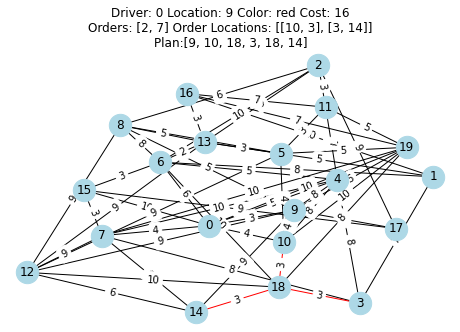

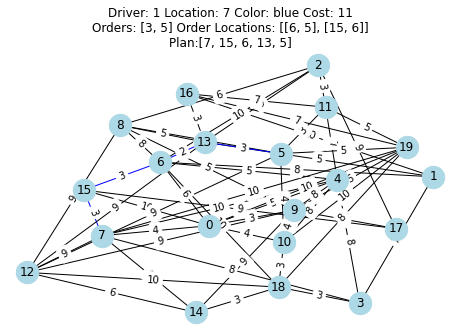

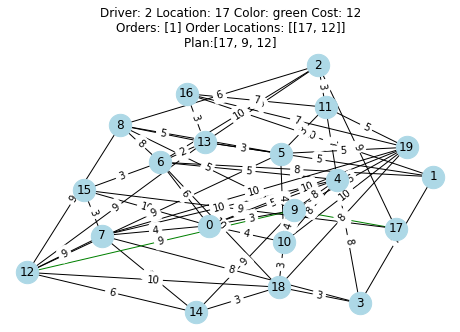

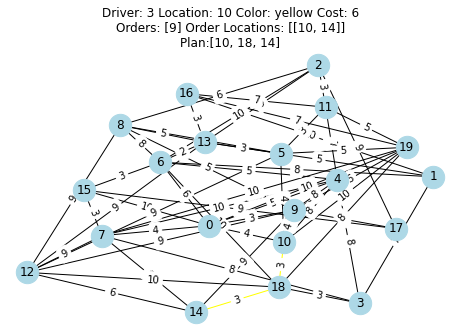

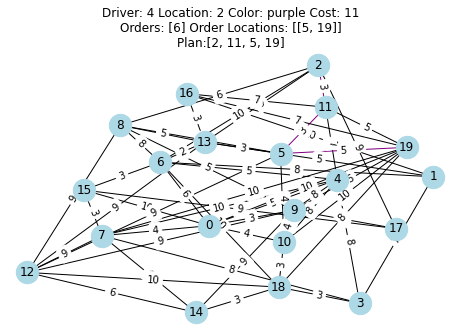

Wall time: 1.07 s


In [30]:
%%time

for d in order_assignment:
    
    plan = (getPlan(d,order_assignment[d]))
    G = getColoredEdges(G.copy(),plan,d)
    
    colors = [G[u][v]['color'] for u,v in G.edges()]

    #Plot graph
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    ax.set_title('Driver: '+str(d)+
                 ' Location: '+str(driverLocation[d])+
                 ' Color: '+str(color_list[d%10])+
                 ' Cost: '+str(order_assignment_cost[d])+
                 '\nOrders: '+str(orderCombo[order_assignment[d]])+
                 ' Order Locations: '+str([orderLocation[i] for i in orderCombo[order_assignment[d]]])+
                 '\nPlan:' +str(plan)
                )
    #pos = nx.spring_layout(G)
    nx.draw(G,pos, node_color='lightblue', with_labels=True, node_size=500, edge_color=colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, label_pos = 0.5)
    plt.show()